# "Beta" Images

${ y = \alpha + \beta*x }$

Wie kann man numerisch ausdrücken, wie gut der Signalverlauf an jeder Stelle im Gehirn dem Modell der erwarteten Hirnaktivität entspricht?

### module importieren

In [1]:
import numpy as np
import pandas as pd

from sklearn.datasets import samples_generator

from nilearn import plotting, image, input_data
from nistats import first_level_model, reporting, regression

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

from ipywidgets import interact

sns.set_context('talk')

/opt/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/opt/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/opt/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/opt/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


## Teil 1: hypothetische Verhaltensdaten mit zwei Bedingungen

Im einfachsten Fall haben wir statt einem Signalverlauf mit vielen Abstufungen auf der x-Achse, ein einfaches 2-Stichproben-Design mit zwei Abstufungen auf der x-Achse. Die zwei Bedingungen sind Dummy-Kodiert als Bedingung "0" und Bedingung "1". Uns interessiert, wie sich die Bedingung "1" von der Bedingung "0" unterscheidet.

### wir simulieren einen Datensatz

vgl. https://machinelearningmastery.com/generate-test-datasets-python-scikit-learn/

Daten erstellen

In [2]:
observations, labels = samples_generator.make_blobs(n_samples=100,
                                                    centers=2, 
                                                    n_features=1,
                                                    random_state=5)

In Tabelle packen

In [3]:
df = pd.DataFrame(dict(y=observations[:,0],x=labels))
df.tail()

,y,x
95,-6.151773,0
96,-5.065696,0
97,-5.661204,0
98,8.603707,1
99,-4.408746,0


Visualisieren

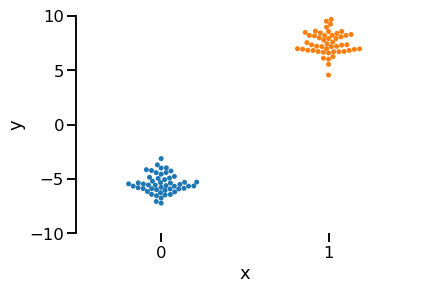

In [4]:
sns.swarmplot(data=df,x='x',y='y')
plt.ylim(-10,10)
sns.despine(bottom=True,trim=True,offset=1)
plt.show()

### Ein Modell erstellen

Das Modell soll ausdrücken, was für einen Zusammenhang wir in den Daten erwarten. Das Modell kann simpel sein oder komplex. D.h. es kann aus einem oder mehreren Regressoren bestehen, welche die Daten erklären. Wir würden gerne in unserem Modell ausdrücken, dass Bedingung "1" mehr macht als Bedingung "0".  
Das folgende wäre ein erster Versuch:

In [5]:
design_matrix = np.array([[0,1]]).T
design_matrix

array([[0],
       [1]])

In [6]:
design_df = pd.DataFrame(design_matrix,columns=['mein Modell'],index=['bedingung1','bedingung2'])
design_df

,mein Modell
bedingung1,0
bedingung2,1


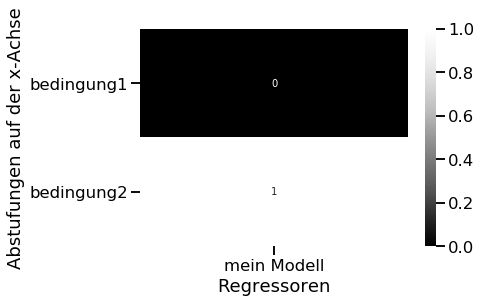

In [7]:
sns.heatmap(design_df,annot=True,cmap='Greys_r')
plt.yticks(rotation=360) # sic
plt.ylabel('Abstufungen auf der x-Achse')
plt.xlabel('Regressoren')
plt.show()

#### Interaktiver Plot: 
Hier probieren wir aus, welche Gewichtung wir dem ersten (und einzigen) Regressor in unserem Modell geben müssen, damit er so viel Varianz wie möglich in unserem Modell erklärt:

In [8]:
def make_plot(weight1):
    sns.swarmplot(data=df,x='x',y='y')
    
    observed = df.groupby('x').mean().values.ravel() # der Einfachheit halber beschreiben wir die Daten hier nur durch ihren Mittelwert; das ist aber nicht korrekt, weil es die Varianz innerhalb der Bedingungen ignoriert
    predicted = (design_matrix*weight1).ravel()

    residual = ((observed-predicted)**2).sum()
    plt.title('sum of squared errors=%.2f'%residual)
    plt.plot(predicted)
    plt.ylim(-10,10)
    sns.despine(bottom=True,trim=True,offset=1)
    plt.show()

In [9]:
interact(make_plot,weight1=(-20,20));

interactive(children=(IntSlider(value=0, description='weight1', max=20, min=-20), Output()), _dom_classes=('wi…

Was ist hier das Problem? Was müssen wir an unserem Modell ändern?

### Variante 2

In [10]:
design_matrix = np.array([[0,1],[1,0]]).T
design_matrix

array([[0, 1],
       [1, 0]])

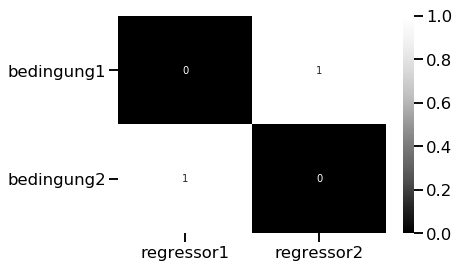

In [11]:
sns.heatmap(pd.DataFrame(design_matrix,columns=['regressor1','regressor2'],
                         index=['bedingung1','bedingung2']),
            annot=True,
            cmap='Greys_r')

plt.yticks(rotation=360)
plt.show()

Es ist plausibel anzunehmen, dass, um die Daten erschöpfend zu beschreiben, beide Bedingungen im Modell vorkommen müssen. Das führt aber die zusätzliche Komplexität ein, nämlich dass wir anschließend überlegen müssen, welche Kombination dieser Regressoren eigentlich ausdrückt, wie Bedingung "1" sich von Bedingung "0" unterscheidet.

In [12]:
def make_plot(weight1,weight2):
    sns.swarmplot(data=df,x='x',y='y')
    prediction1 = design_matrix[:,0]*weight1
    prediction2 = design_matrix[:,1]*weight2

    sum_of_predictions = prediction1 + prediction2
    plt.plot(sum_of_predictions,label='sum of preds')
    
    plt.plot(prediction1,'--',label='pred1')
    plt.plot(prediction2,'--',label='pred2')
    
    
    observed = df.groupby('x').mean().values.ravel()
    predicted = sum_of_predictions.ravel()
    residual = ((observed-predicted)**2).sum()
    plt.title('sum of squared errors=%.2f'%residual)
    
    plt.ylim(-10,10)
    sns.despine(bottom=True,trim=True,offset=1)
    plt.legend(loc=(1,0.8))
    plt.show()

In [13]:
interact(make_plot,weight1=(-10,10),weight2=(-10,10));

interactive(children=(IntSlider(value=0, description='weight1', max=10, min=-10), IntSlider(value=0, descripti…

Wie kann nun ausgedrückt werden, wie sich Bedingung 1 von 0 unterscheidet?

### Variante 3: ein Modell mit einer "Konstante"

In [14]:
design_matrix = np.array([[0,1],[1,1]]).T
design_matrix

array([[0, 1],
       [1, 1]])

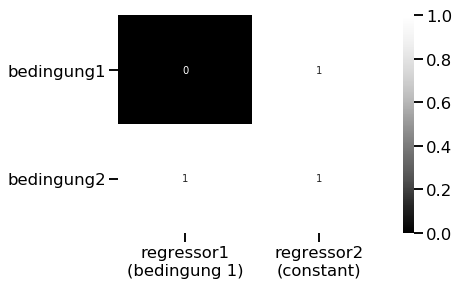

In [15]:
sns.heatmap(pd.DataFrame(design_matrix,columns=['regressor1\n(bedingung 1)','regressor2\n(constant)'],
                         index=['bedingung1','bedingung2']),
            annot=True,
            cmap='Greys_r')

plt.yticks(rotation=360)
plt.show()

In [16]:
def make_plot(weight1,weight2):
    sns.swarmplot(data=df,x='x',y='y')
    prediction1 = design_matrix[:,0]*weight1
    prediction2 = design_matrix[:,1]*weight2

    sum_of_predictions = prediction1 + prediction2
    plt.plot(sum_of_predictions,label='sum of preds')
    
    plt.plot(prediction1,'--',label='pred1')
    plt.plot(prediction2,'--',label='pred2')
    
    
    observed = df.groupby('x').mean().values.ravel()
    predicted = sum_of_predictions.ravel()
    residual = ((observed-predicted)**2).sum()
    plt.title('sum of squared errors=%.2f'%residual)
    
    plt.ylim(-10,10)
    sns.despine(bottom=True,trim=True,offset=1)
    plt.legend(loc=(1,0.8))
    plt.show()

In [17]:
interact(make_plot,weight1=(-10,20),weight2=(-10,10));

interactive(children=(IntSlider(value=5, description='weight1', max=20, min=-10), IntSlider(value=0, descripti…

* Was drücken die Gewichtungen der jeweiligen Regressoren aus? 
* Wie kann der Mittelwert von Bedingung 0 ausgedrückt werden? 
* Wie der Mittelwert von Bedingung 1? 
* Wie die Differenz der beiden Bedingungen?

Wie könnten wir dieses Modell zu dieser Formel in Beziehung setzen?  

$${ y = \alpha + \beta*x }$$  

Was ist hier alpha, was beta? Macht es Sinn, dass alpha einen additiven Zusammenhang zu unseren Daten hat, während beta einen multiplikativen Zusammenhang hat?

### Variante 4: Jede Bedingung hat einen Regressor und es gibt eine Konstante

In [18]:
design_matrix = np.array([[0,1],[1,0],[1,1]]).T
design_matrix

array([[0, 1, 1],
       [1, 0, 1]])

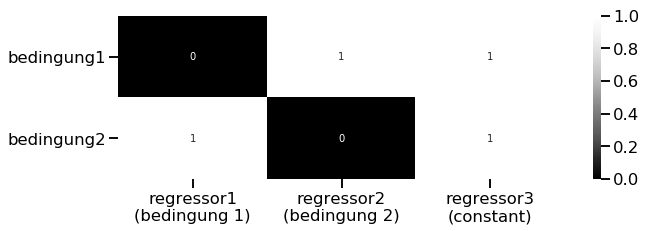

In [19]:
plt.figure(figsize=(10,3))
sns.heatmap(pd.DataFrame(design_matrix,columns=['regressor1\n(bedingung 1)','regressor2\n(bedingung 2)','regressor3\n(constant)'],
                         index=['bedingung1','bedingung2']),
            annot=True,
            cmap='Greys_r')

plt.yticks(rotation=360)
plt.show()

In [20]:
def make_plot(weight1,weight2,weight3):
    sns.swarmplot(data=df,x='x',y='y')
    prediction1 = design_matrix[:,0]*weight1
    prediction2 = design_matrix[:,1]*weight2
    prediction3 = design_matrix[:,2]*weight3
    
    sum_of_predictions = prediction1 + prediction2 + prediction3
    plt.plot(sum_of_predictions,label='sum of preds')
    
    plt.plot(prediction1,'--',label='pred1')
    plt.plot(prediction2,'--',label='pred2')
    plt.plot(prediction3,'--',label='pred3')
    
    observed = df.groupby('x').mean().values.ravel()
    predicted = sum_of_predictions.ravel()
    residual = ((observed-predicted)**2).sum()
    plt.title('sum of squared errors=%.2f'%residual)
    
    plt.ylim(-10,10)
    sns.despine(bottom=True,trim=True,offset=1)
    plt.legend(loc=(1,0.8))
    plt.show()

In [21]:
interact(make_plot,weight1=(-10,20),weight2=(-10,10),weight3=(-10,10));

interactive(children=(IntSlider(value=5, description='weight1', max=20, min=-10), IntSlider(value=0, descripti…

Macht es Sinn, 3 Regressoren zu haben? Erleichtert es die Interpretation?

## Das gleiche Prinzip, angewendet auf unsere fMRT-Daten

Wir machen alles genauso wie bisher, nur dass wir statt zweier Bedingungen nun davon ausgehen, dass es einen Signalverlauf mit 203 Zeitpunkten gibt 

### Das Design

In [22]:
df = pd.read_csv('../data/sub-01_task-imagery_run-02_events.tsv',sep='\t')
df = df.rename(columns={'trial_domain':'trial_type'})

In [23]:
df

,onset,duration,trial_type,trial_subdomain,trial_content
0,0,30,MOTORIK,Haende,Boxen
1,30,30,GESICHTER,Bekannt,Kommilitonen
2,60,30,SPRACHE,Sprechen,Lebensmittel
3,90,30,EMOTION,Negativ,Waldbrand
4,120,30,RUHE,Ruhe,Ruhe
5,150,30,GESICHTER,Beruehmt,Serienschauspieler
6,180,30,SPRACHE,Schreiben,Tiere
7,210,30,MOTORIK,Fuesse,Hochseil
8,240,30,EMOTION,Positiv,See
9,270,30,RUHE,Ruhe,Ruhe


#### Der Einfachheit halber nehmen wir uns erstmal nur die Bedingung Sprache vor und vergleichen sie mit allen anderen Zeitpunkten

In [24]:
df = df[df.loc[:,'trial_type']=='SPRACHE']

In [25]:
df

,onset,duration,trial_type,trial_subdomain,trial_content
2,60,30,SPRACHE,Sprechen,Lebensmittel
6,180,30,SPRACHE,Schreiben,Tiere
10,300,30,SPRACHE,Sprechen,Vornamen
16,480,30,SPRACHE,Schreiben,Staedte


### Wir laden die fMRT Daten

In [26]:
fmri_img = '../data/sub-01_task-imagery_run-02_bold_space-MNI152NLin2009cAsym_preproc.nii.gz'
fmri_img = image.smooth_img(fmri_img,fwhm=8)

### Wir verbinden Daten und Design

In [27]:
fmri_glm = first_level_model.FirstLevelModel(t_r=3,
                                             hrf_model='spm',
                                             noise_model='ols',
                                             drift_model=None,
                                             standardize=False,
                                             signal_scaling=False
                                            )

In [28]:
fmri_glm = fmri_glm.fit(fmri_img, df)

/opt/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/miniconda3/lib/python3.7/site-packages/nistats/hemodynamic_models.py:268: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  frame_times.max() * (1 + 1. / (n - 1)), n_hr)
/opt/miniconda3/lib/python3.7/site-packages/nistats/hemodynamic_models.py:55: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  time_stamps = np.linspace(0, time_length, float(time_length) / dt)


In [29]:
fmri_glm

FirstLevelModel(drift_model=None, drift_order=1, fir_delays=[0],
        hrf_model='spm', mask=None, memory=Memory(location=None),
        memory_level=1, min_onset=-24, minimize_memory=True, n_jobs=1,
        noise_model='ols', period_cut=128, signal_scaling=False,
        slice_time_ref=0.0, smoothing_fwhm=None, standardize=False,
        subject_label=None, t_r=3, target_affine=None, target_shape=None,
        verbose=0)

### Es gibt nun auch eine Design-Matrix

In [30]:
design_matrix = fmri_glm.design_matrices_[-1]

Visualisierung mit der Zeit auf der x-Achse

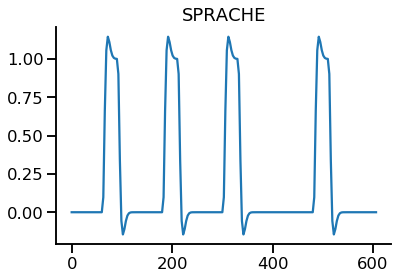

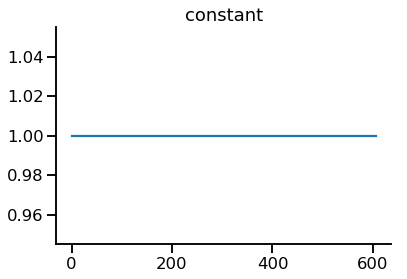

In [31]:
for column in design_matrix:
    plt.plot(design_matrix.loc[:,column])
    plt.title(column)
    sns.despine()
    plt.show()

Das gleiche aus der "Vogelperspektive" mit Zeit auf der y-Achse

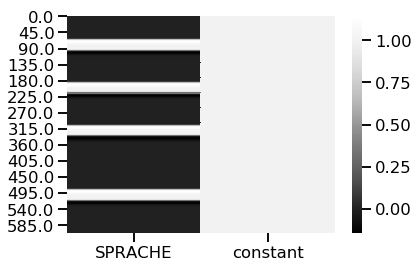

In [32]:
sns.heatmap(design_matrix,cmap='Greys_r');

## Finden der Gewichte (betas), so dass die beiden Regressoren die Daten möglichst gut beschreiben

### Wir picken uns die Daten aus einem Voxel aus

In [33]:
language_seed = (-55,10,20)

In [34]:
seed_masker = input_data.NiftiSpheresMasker(seeds=[language_seed],radius=1).fit()

In [35]:
voxel_data = seed_masker.transform(fmri_img)

/opt/miniconda3/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


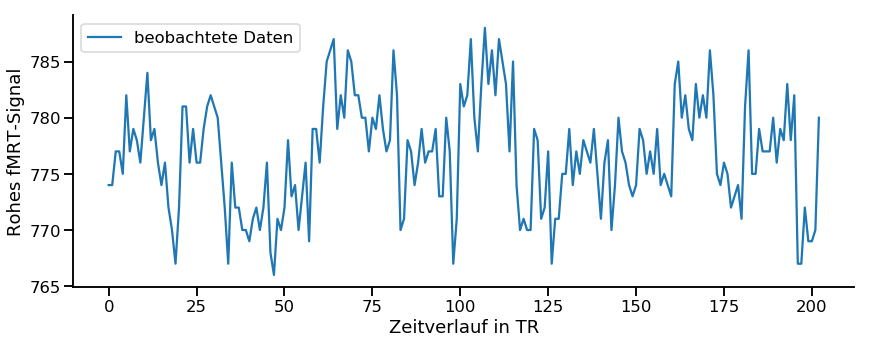

In [36]:
plt.figure(figsize=(14,5))
plt.plot(voxel_data,label='beobachtete Daten')
plt.xlabel('Zeitverlauf in TR')
plt.ylabel('Rohes fMRT-Signal')
plt.legend()
sns.despine()
plt.show()

### Mit nur einem Regressor:

In [37]:
def make_plot(weight1):#,weight2):
    
    plt.plot(voxel_data)
    prediction1 = (design_matrix.loc[:,'SPRACHE']*weight1).values
   # prediction2 = (design_matrix.loc[:,'constant']*weight2).values

    sum_of_predictions = prediction1# + prediction2
    #plt.plot(sum_of_predictions,label='sum of preds')
    
    plt.plot(prediction1,'--',label='pred1')
    #plt.plot(prediction2,'--',label='pred2')
    
    observed = voxel_data.ravel()
    predicted = sum_of_predictions.ravel()
    residual = ((observed-predicted)**2).sum()
    plt.title('sum of squared errors=%.2f'%residual)
    
    sns.despine(bottom=True,trim=True,offset=1)
    plt.legend(loc=(1,0.8))
    plt.show()

In [38]:
interact(make_plot,
         weight1=(-1000,1000,10));

interactive(children=(IntSlider(value=0, description='weight1', max=1000, min=-1000, step=10), Output()), _dom…

Die Konstante ist die einfachste Form von "Störvariablen". Ohne sie würde der Fit der HRF nicht gut funktionieren. Erst wenn wir sie mit aufnehmen, können wir durch Manipulation der Gewichtung der HRF die Daten fitten.

In [39]:
def make_plot(weight1,weight2):
    plt.plot(voxel_data)
    prediction1 = (design_matrix.loc[:,'SPRACHE']*weight1).values
    prediction2 = (design_matrix.loc[:,'constant']*weight2).values

    sum_of_predictions = prediction1 + prediction2
    plt.plot(sum_of_predictions,label='sum of preds')
    
    #plt.plot(prediction1,'--',label='pred1')
    #plt.plot(prediction2,'--',label='pred2')
    
    observed = voxel_data.ravel()
    predicted = sum_of_predictions.ravel()
    residual = ((observed-predicted)**2).sum()
    
    plt.title('sum of squared errors=%.2f'%residual)
    
    sns.despine(bottom=True,trim=True,offset=1)
    plt.legend(loc=(1,0.8))
    plt.show()

In [40]:
interact(make_plot,
         weight1=(-20,20),
         weight2=(0,790));

interactive(children=(IntSlider(value=0, description='weight1', max=20, min=-20), IntSlider(value=395, descrip…

## Variante 2: "Explizite Baseline"

Wir fügen einen zweiten Regressor hinzu, der die Zeitpunkte ohne Sprache modellieren soll.

In [41]:
design_matrix.loc[:,'BASELINE'] = 1-design_matrix.loc[:,'SPRACHE']
design_matrix = design_matrix[['SPRACHE','BASELINE','constant']]

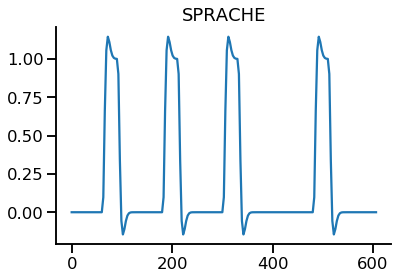

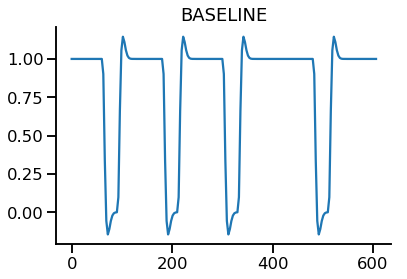

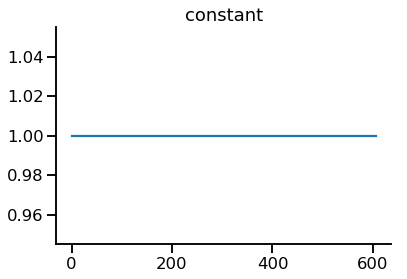

In [42]:
for column in design_matrix:
    plt.plot(design_matrix.loc[:,column])
    plt.title(column)
    sns.despine()
    plt.show()

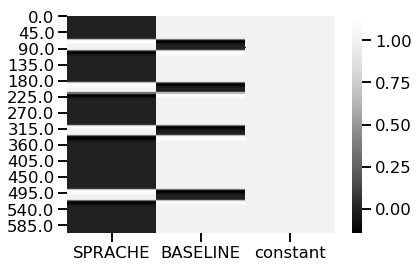

In [43]:
sns.heatmap(design_matrix,cmap='Greys_r');

#### Wir versuchen die besten Gewichtungen (betas) für diese drei Regressoren zu finden

In [44]:
def make_plot(weight1,weight2,weight3):
    plt.plot(voxel_data)
    prediction1 = (design_matrix.loc[:,'SPRACHE']*weight1).values
    prediction2 = (design_matrix.loc[:,'BASELINE']*weight2).values
    prediction3 = (design_matrix.loc[:,'constant']*weight3).values

    sum_of_predictions = prediction1 + prediction2 + prediction3
    plt.plot(sum_of_predictions,label='sum of preds')

    observed = voxel_data.ravel()
    predicted = sum_of_predictions.ravel()
    residual = ((observed-predicted)**2).sum()
    
    plt.title('sum of squared errors=%.2f'%residual)
    
    sns.despine(bottom=True,trim=True,offset=1)
    plt.legend(loc=(1,0.8))
    plt.show()

In [45]:
interact(make_plot,
         weight1=(-20,20),
        weight2=(-20,20),
         weight3=(740,790));

interactive(children=(IntSlider(value=0, description='weight1', max=20, min=-20), IntSlider(value=0, descripti…

Macht es Sinn, 3 Regressoren zu haben? Erleichtert es die Interpretation?

## Das gleiche mit allen Bedingungen

In [46]:
df = pd.read_csv('../data/sub-01_task-imagery_run-02_events.tsv',sep='\t')
df = df.rename(columns={'trial_domain':'trial_type'})
fmri_glm = fmri_glm.fit(fmri_img, df)
design_matrix = fmri_glm.design_matrices_[-1]

/opt/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/miniconda3/lib/python3.7/site-packages/nistats/hemodynamic_models.py:268: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  frame_times.max() * (1 + 1. / (n - 1)), n_hr)
/opt/miniconda3/lib/python3.7/site-packages/nistats/hemodynamic_models.py:55: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  time_stamps = np.linspace(0, time_length, float(time_length) / dt)


In [47]:
def make_plot(wSprache,wMotorik,wGesichter,wEmotion,wRuhe,wConstant):
    plt.plot(voxel_data)
    prediction1 = (design_matrix.loc[:,'SPRACHE']*wSprache).values
    prediction2 = (design_matrix.loc[:,'MOTORIK']*wMotorik).values
    prediction3 = (design_matrix.loc[:,'GESICHTER']*wGesichter).values
    prediction4 = (design_matrix.loc[:,'EMOTION']*wEmotion).values
    prediction5 = (design_matrix.loc[:,'RUHE']*wRuhe).values
    prediction6 = (design_matrix.loc[:,'constant']*wConstant).values

    sum_of_predictions = prediction1 + prediction2 + prediction3 + prediction4 + prediction5 + prediction6
    plt.plot(sum_of_predictions,label='sum of preds')

    observed = voxel_data.ravel()
    predicted = sum_of_predictions.ravel()
    residual = ((observed-predicted)**2).sum()
    
    plt.title('sum of squared errors=%.2f'%residual)
    
    sns.despine(bottom=True,trim=True,offset=1)
    plt.legend(loc=(1,0.8))
    plt.show()

In [48]:
interact(make_plot,
         wSprache=(-20,20),
         wMotorik=(-20,20),
         wGesichter=(-20,20),
         wEmotion=(-20,20),
         wRuhe=(-20,20),
         wConstant=(740,790));

interactive(children=(IntSlider(value=0, description='wSprache', max=20, min=-20), IntSlider(value=0, descript…

Wie müssen wir die Betas kombinieren, um den Differenz Sprache vs. alle anderen Bedingungen zu bekommen?

## Das Ganze automatisch machen

d.h. den besten Fit finden

In [49]:
my_model = regression.OLSModel(design_matrix)

In [50]:
my_results = my_model.fit(voxel_data)

### bester fit vs. beobachtete Daten

In [51]:
this_predicted = my_results.predicted

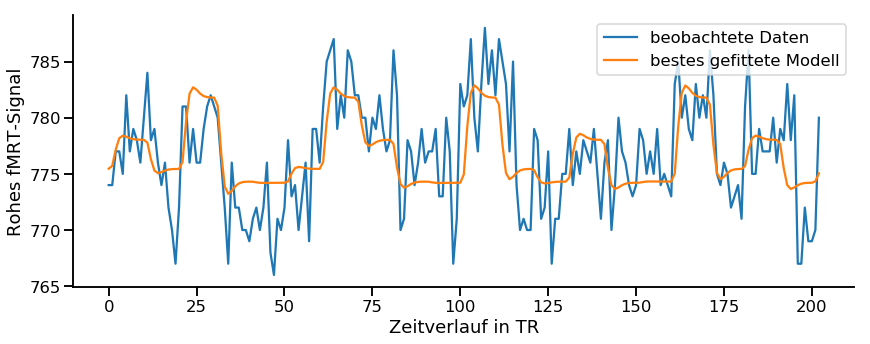

In [52]:
plt.figure(figsize=(14,5))
plt.plot(voxel_data,label='beobachtete Daten')
plt.plot(this_predicted,label='bestes gefittete Modell')
plt.xlabel('Zeitverlauf in TR')
plt.ylabel('Rohes fMRT-Signal')
plt.legend()
sns.despine()
plt.show()

## Wie muss ich die einzelnen Regressoren gewichten, um das gefittete Modell zu bekommen?

Die Gewichte sind in der Variablen "theta" hinterlegt. Das ist das was wir sonst "beta" nennen.

In [53]:
these_weights = my_results.theta

In [54]:
these_weights

array([[-1.15304889e+00],
       [-2.14303106e-02],
       [ 2.56789746e+00],
       [-1.25304305e+00],
       [ 6.32607979e+00],
       [ 7.75462272e+02]])

In [55]:
weights_df = pd.DataFrame(zip(design_matrix.columns,these_weights))
weights_df.columns = ['condition','weight']
weights_df.index = weights_df.loc[:,'condition']
weights_df = weights_df.drop('condition',axis=1)
weights_df = weights_df.applymap(lambda x:x[-1])
weights_df.loc[['SPRACHE','MOTORIK','GESICHTER','EMOTION','RUHE','constant']]

,weight
condition,
SPRACHE,6.326080
MOTORIK,2.567897
GESICHTER,-0.021430
EMOTION,-1.153049
RUHE,-1.253043
constant,775.462272


So sieht das ursprüngliche Modell aus (alle betas = 1)

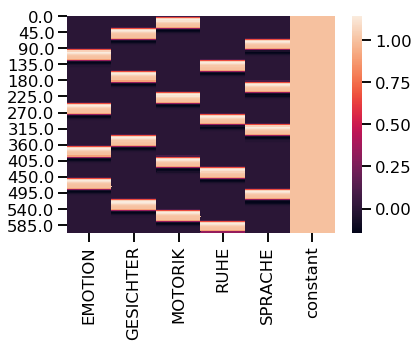

In [56]:
sns.heatmap(design_matrix);

So sieht es nach Multiplikation mit den betas aus:

In [57]:
apply_weight = lambda x: x*weights_df.loc[x.name,'weight']

In [58]:
multi_df = design_matrix.apply(apply_weight)[['SPRACHE','MOTORIK','GESICHTER','EMOTION','RUHE','constant']]

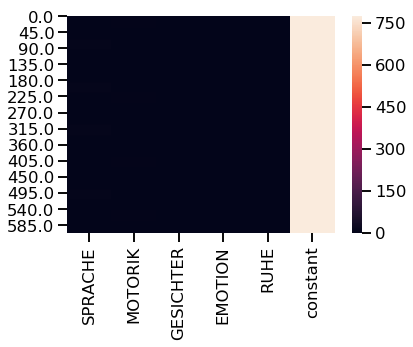

In [59]:
sns.heatmap(multi_df);

Bzw.

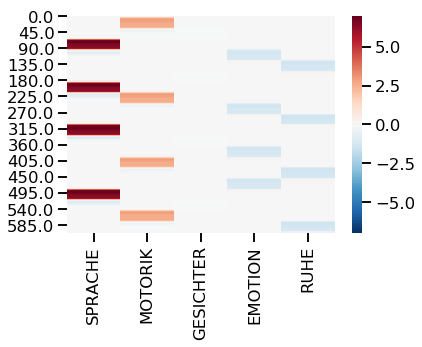

In [60]:
sns.heatmap(multi_df.drop('constant',axis=1),cmap='RdBu_r',vmin=-7,vmax=7);

Die selben gewichteten Regressoren, visualisiert mit Zeit auf der x-Achse:

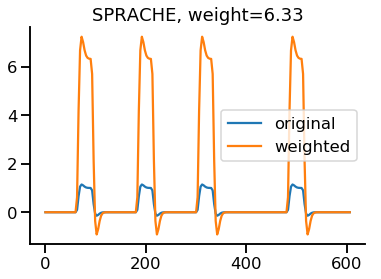

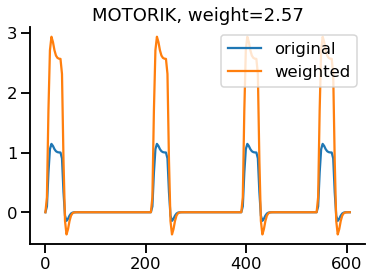

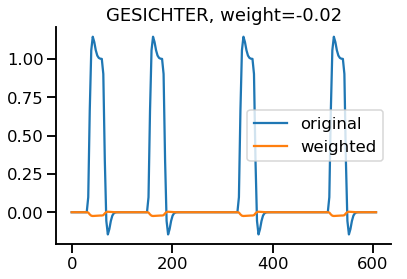

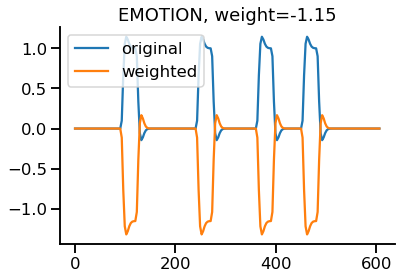

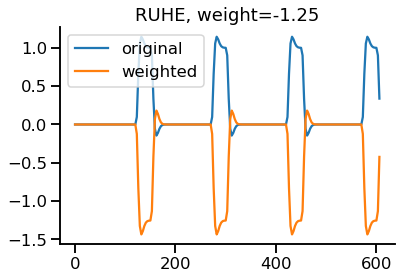

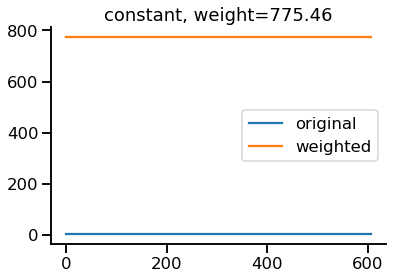

In [61]:
for c in multi_df.columns:
    plt.plot(design_matrix.loc[:,c],label='original')
    plt.plot(multi_df.loc[:,c],label='weighted')
    plt.legend()
    plt.title('%s, weight=%.2f'%(c, weights_df.loc[c,'weight']))
    sns.despine()
    plt.show()

Summe der gewichteten Regressoren

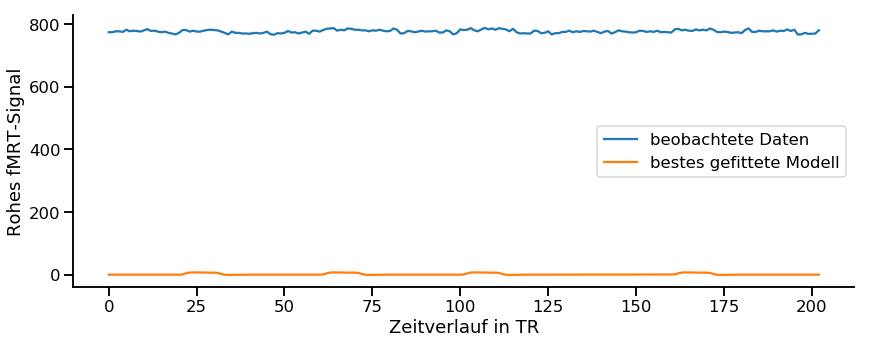

In [62]:
plt.figure(figsize=(14,5))

plt.plot(voxel_data,label='beobachtete Daten')

sum_of_weighted = (  
                      multi_df['SPRACHE'] 
                   #+ multi_df['MOTORIK'] 
                   #+ multi_df['GESICHTER'] 
                   #+ multi_df['EMOTION'] 
                   #+ multi_df['RUHE'] 
                   #+ multi_df['constant'] 
                  )
plt.plot(sum_of_weighted.values,label='bestes gefittete Modell')
#plt.plot(my_results.predicted,'--',label='nistats prediction')

plt.xlabel('Zeitverlauf in TR')
plt.ylabel('Rohes fMRT-Signal')
plt.legend()
sns.despine()
plt.show()

## Das gleiche, automatisch mit nistats

Onsets

In [63]:
df = pd.read_csv('../data/sub-01_task-imagery_run-02_events.tsv',sep='\t')
df = df.rename(columns={'trial_domain':'trial_type'})

In [64]:
df

,onset,duration,trial_type,trial_subdomain,trial_content
0,0,30,MOTORIK,Haende,Boxen
1,30,30,GESICHTER,Bekannt,Kommilitonen
2,60,30,SPRACHE,Sprechen,Lebensmittel
3,90,30,EMOTION,Negativ,Waldbrand
4,120,30,RUHE,Ruhe,Ruhe
5,150,30,GESICHTER,Beruehmt,Serienschauspieler
6,180,30,SPRACHE,Schreiben,Tiere
7,210,30,MOTORIK,Fuesse,Hochseil
8,240,30,EMOTION,Positiv,See
9,270,30,RUHE,Ruhe,Ruhe


Modell fitten. Wir brauchen nur zwei Dinge:  
* die Datei mit den fMRT-Daten
* die Tabelle mit den Onsets

In [65]:
fmri_glm = fmri_glm.fit(fmri_img, df)

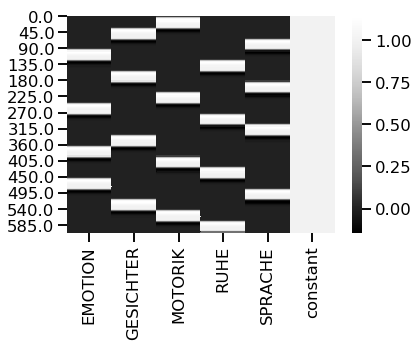

In [66]:
design_matrix = fmri_glm.design_matrices_[-1]
sns.heatmap(design_matrix,cmap='Greys_r')

Der "Kontrast" Sprache gegen alles andere:

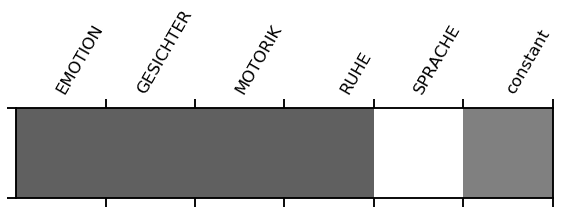

In [69]:
sprache_vs_alles_andere = np.array([-0.25,-0.25,-0.25,-0.25,+1,0])
reporting.plot_contrast_matrix(sprache_vs_alles_andere, design_matrix=design_matrix);

Die Gewichte für jedes Voxel finden

In [70]:
beta_img = fmri_glm.compute_contrast(sprache_vs_alles_andere,
                                     output_type='effect_size')

/opt/miniconda3/lib/python3.7/site-packages/nilearn/plotting/displays.py:600: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(axes, collections.Sequence):
/opt/miniconda3/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


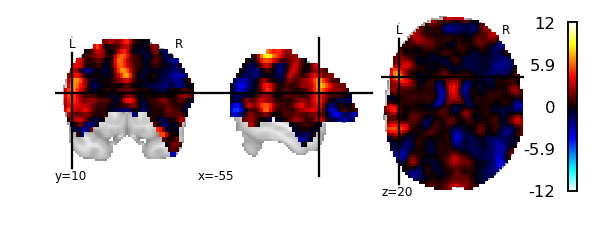

In [71]:
plotting.plot_stat_map(beta_img,cut_coords=(-55,10,20))

Daten aus usprünglichem Voxel extrahieren

In [72]:
seed_masker.seeds_

[[-55, 10, 20]]

Passt der Wert ("beta") der Karte an dieser Stelle zu dem Gewichtung die wir in den Modellen oben händisch gewählt haben?

In [74]:
seed_masker.transform(beta_img)

/opt/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/miniconda3/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


array([[6.29098599]])